In [61]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [62]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [63]:
import optax

In [64]:
class MMD:

    def __init__(self, scales, space):
        gammas = 1 / (2 * (scales**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        self.scales = scales

    def k_expval(self, px, py):
        # Kernel expectation value
        return px @ self.K @ py

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

In [70]:
from functools import partial

class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py  # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

## Mixture of Gaussains

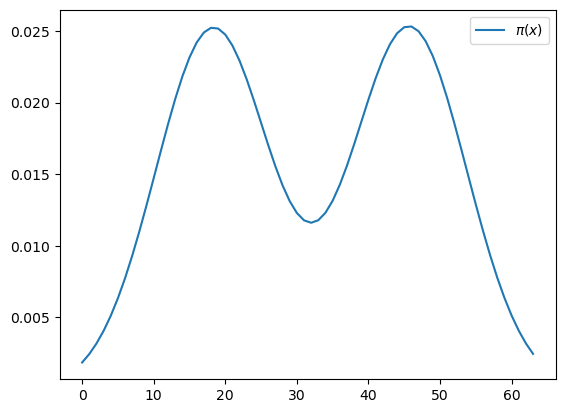

In [72]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]
sigmas = [x_max / 8] * 2
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

In [86]:
def QCBM_N_layers_run(n_layers = 4):
    dev = qml.device("default.qubit", wires=n_qubits)

    wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    weights = np.random.random(size=wshape)

    @qml.qnode(dev)
    def circuit(weights):
        qml.StronglyEntanglingLayers(
            weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
        )
        return qml.probs()


    jit_circuit = jax.jit(circuit)

    qml.draw_mpl(circuit, level="device")(weights)
    plt.show()

    bandwidth = jnp.array([0.25, 60])
    space = jnp.arange(2**n_qubits)

    mmd = MMD(bandwidth, space)
    qcbm = QCBM(jit_circuit, mmd, data)

    opt = optax.adam(learning_rate=0.1)
    opt_state = opt.init(weights)

    history = []
    divs = []
    n_iterations = int(200 / n_layers)

    @jax.jit
    def update_step(params, opt_state):
        (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
        return params, opt_state, loss_val, kl_div

    for i in range(n_iterations):
        weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

        # if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

        history.append(loss_val)
        divs.append(kl_div)
    
    qcbm_probs = qcbm.circ(weights)

    plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
    plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

    plt.xlabel("Samples")
    plt.ylabel("Prob. Distribution")

    plt.legend()
    plt.show()

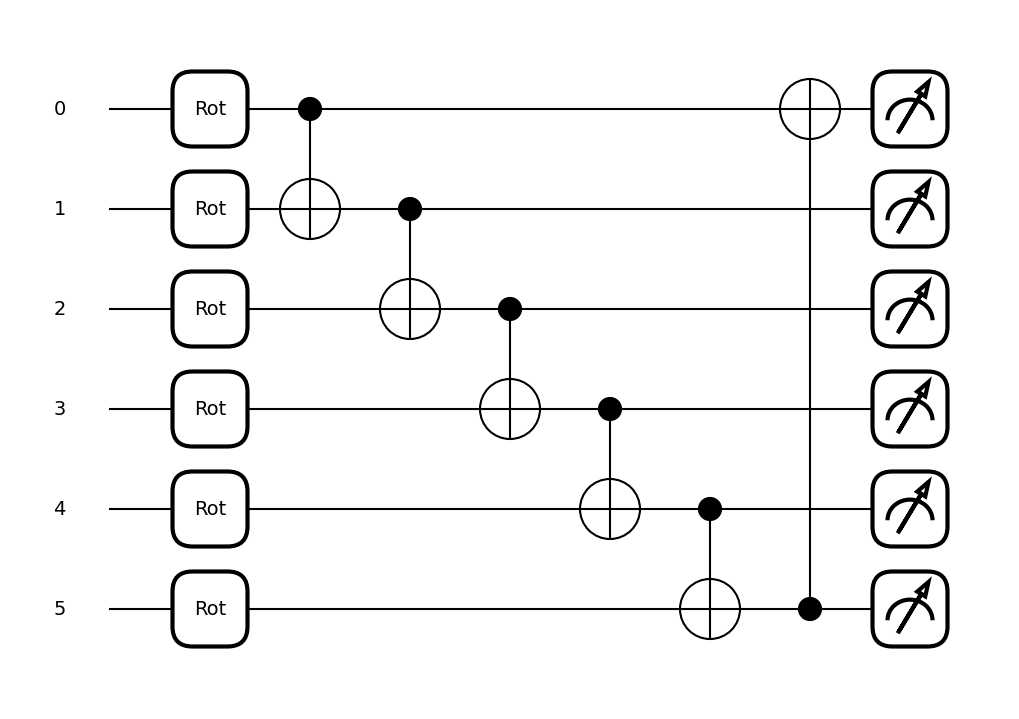

Step: 0 Loss: 0.1864 KL-div: 4.8137
Step: 1 Loss: 0.1313 KL-div: 3.7086
Step: 2 Loss: 0.0898 KL-div: 2.8664
Step: 3 Loss: 0.0605 KL-div: 2.2078
Step: 4 Loss: 0.0407 KL-div: 1.6896
Step: 5 Loss: 0.0276 KL-div: 1.2830
Step: 6 Loss: 0.0188 KL-div: 0.9656
Step: 7 Loss: 0.0130 KL-div: 0.7199
Step: 8 Loss: 0.0090 KL-div: 0.5316
Step: 9 Loss: 0.0063 KL-div: 0.3895
Step: 10 Loss: 0.0045 KL-div: 0.2845
Step: 11 Loss: 0.0032 KL-div: 0.2093
Step: 12 Loss: 0.0023 KL-div: 0.1579
Step: 13 Loss: 0.0018 KL-div: 0.1256
Step: 14 Loss: 0.0016 KL-div: 0.1082
Step: 15 Loss: 0.0015 KL-div: 0.1026
Step: 16 Loss: 0.0016 KL-div: 0.1059
Step: 17 Loss: 0.0018 KL-div: 0.1156
Step: 18 Loss: 0.0021 KL-div: 0.1297
Step: 19 Loss: 0.0025 KL-div: 0.1464
Step: 20 Loss: 0.0029 KL-div: 0.1641
Step: 21 Loss: 0.0033 KL-div: 0.1816
Step: 22 Loss: 0.0037 KL-div: 0.1976
Step: 23 Loss: 0.0041 KL-div: 0.2115
Step: 24 Loss: 0.0043 KL-div: 0.2224
Step: 25 Loss: 0.0045 KL-div: 0.2301
Step: 26 Loss: 0.0046 KL-div: 0.2342
Step: 27 Lo

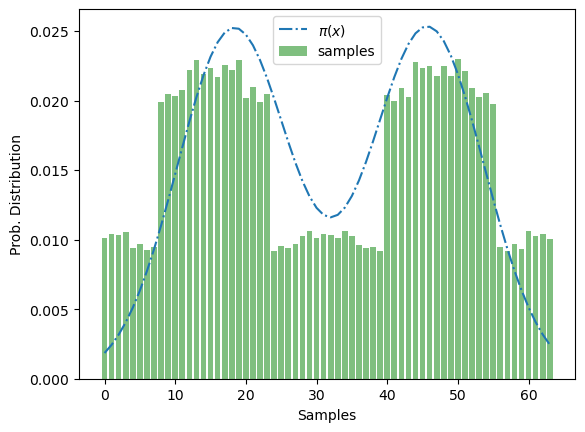

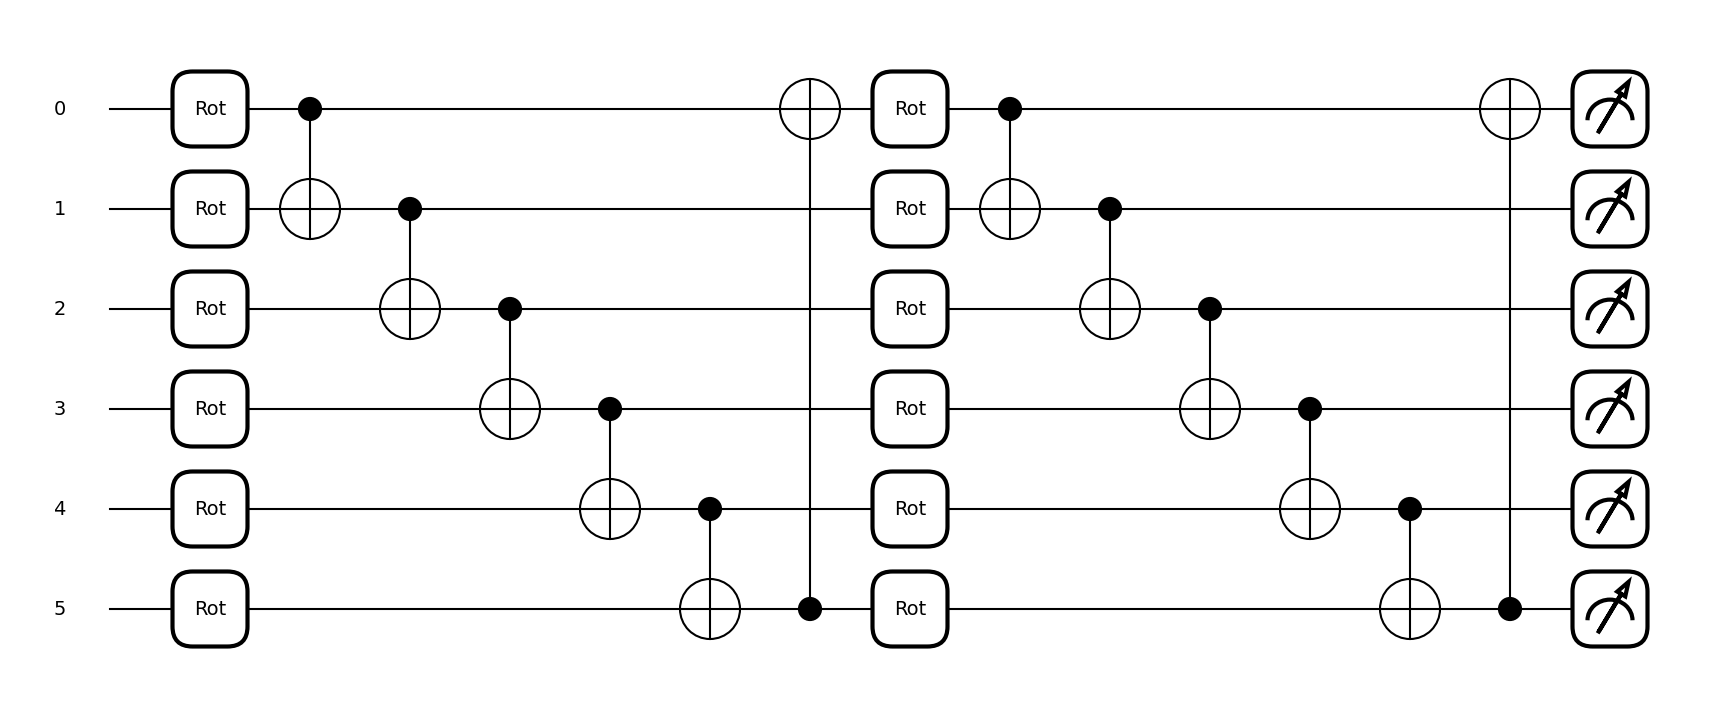

Step: 0 Loss: 0.0324 KL-div: 1.8030
Step: 1 Loss: 0.0197 KL-div: 1.4530
Step: 2 Loss: 0.0144 KL-div: 1.0227
Step: 3 Loss: 0.0112 KL-div: 0.7297
Step: 4 Loss: 0.0084 KL-div: 0.5461
Step: 5 Loss: 0.0067 KL-div: 0.4429
Step: 6 Loss: 0.0062 KL-div: 0.4051
Step: 7 Loss: 0.0061 KL-div: 0.3788
Step: 8 Loss: 0.0058 KL-div: 0.3546
Step: 9 Loss: 0.0051 KL-div: 0.3239
Step: 10 Loss: 0.0044 KL-div: 0.2796
Step: 11 Loss: 0.0037 KL-div: 0.2305
Step: 12 Loss: 0.0030 KL-div: 0.1908
Step: 13 Loss: 0.0027 KL-div: 0.1703
Step: 14 Loss: 0.0027 KL-div: 0.1726
Step: 15 Loss: 0.0031 KL-div: 0.1939
Step: 16 Loss: 0.0035 KL-div: 0.2220
Step: 17 Loss: 0.0037 KL-div: 0.2419
Step: 18 Loss: 0.0036 KL-div: 0.2447
Step: 19 Loss: 0.0033 KL-div: 0.2309
Step: 20 Loss: 0.0029 KL-div: 0.2071
Step: 21 Loss: 0.0025 KL-div: 0.1812
Step: 22 Loss: 0.0021 KL-div: 0.1582
Step: 23 Loss: 0.0018 KL-div: 0.1404
Step: 24 Loss: 0.0017 KL-div: 0.1283
Step: 25 Loss: 0.0016 KL-div: 0.1211
Step: 26 Loss: 0.0016 KL-div: 0.1164
Step: 27 Lo

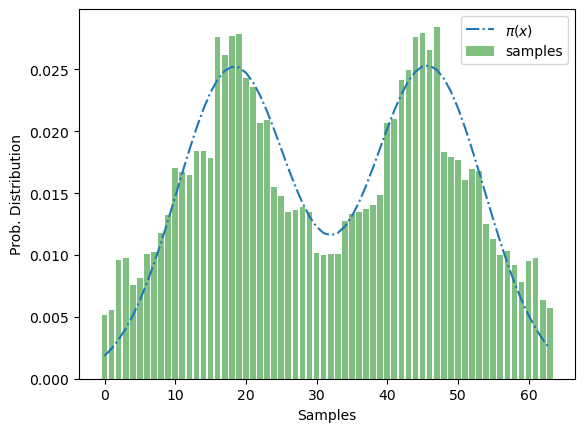

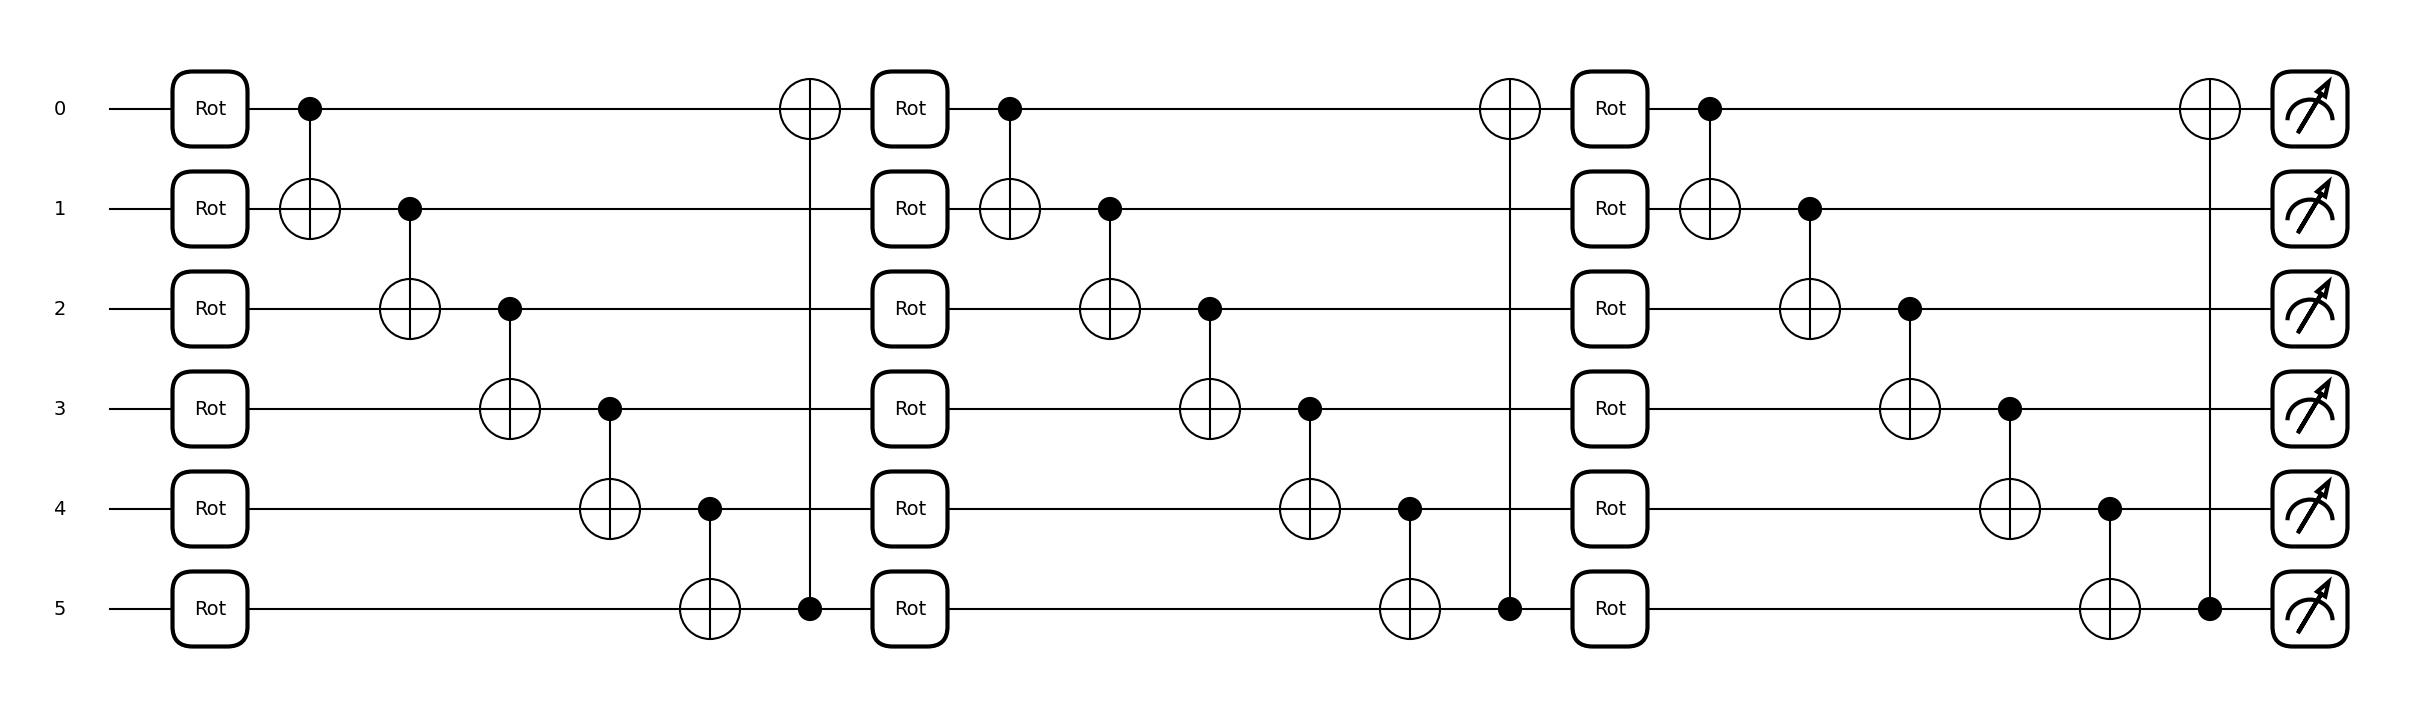

Step: 0 Loss: 0.0314 KL-div: 1.5090
Step: 1 Loss: 0.0157 KL-div: 1.2615
Step: 2 Loss: 0.0100 KL-div: 0.9966
Step: 3 Loss: 0.0067 KL-div: 0.6747
Step: 4 Loss: 0.0060 KL-div: 0.5065
Step: 5 Loss: 0.0058 KL-div: 0.4107
Step: 6 Loss: 0.0050 KL-div: 0.3745
Step: 7 Loss: 0.0046 KL-div: 0.4525
Step: 8 Loss: 0.0046 KL-div: 0.4393
Step: 9 Loss: 0.0045 KL-div: 0.4160
Step: 10 Loss: 0.0042 KL-div: 0.4064
Step: 11 Loss: 0.0038 KL-div: 0.3530
Step: 12 Loss: 0.0036 KL-div: 0.3147
Step: 13 Loss: 0.0035 KL-div: 0.2860
Step: 14 Loss: 0.0032 KL-div: 0.2610
Step: 15 Loss: 0.0029 KL-div: 0.2401
Step: 16 Loss: 0.0025 KL-div: 0.2226
Step: 17 Loss: 0.0022 KL-div: 0.2067
Step: 18 Loss: 0.0020 KL-div: 0.1968
Step: 19 Loss: 0.0019 KL-div: 0.1966
Step: 20 Loss: 0.0018 KL-div: 0.2053
Step: 21 Loss: 0.0019 KL-div: 0.2190
Step: 22 Loss: 0.0019 KL-div: 0.2318
Step: 23 Loss: 0.0018 KL-div: 0.2566
Step: 24 Loss: 0.0017 KL-div: 0.2160
Step: 25 Loss: 0.0015 KL-div: 0.1875
Step: 26 Loss: 0.0014 KL-div: 0.1703
Step: 27 Lo

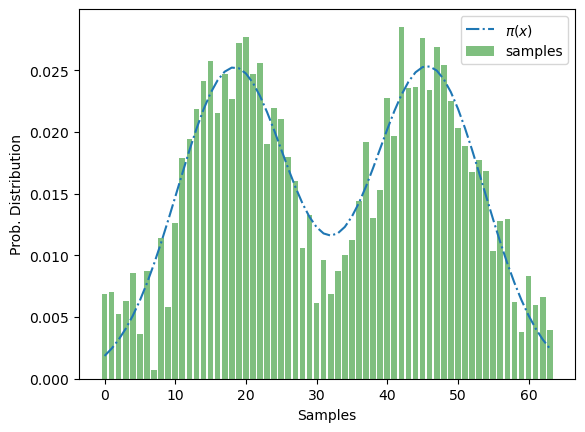

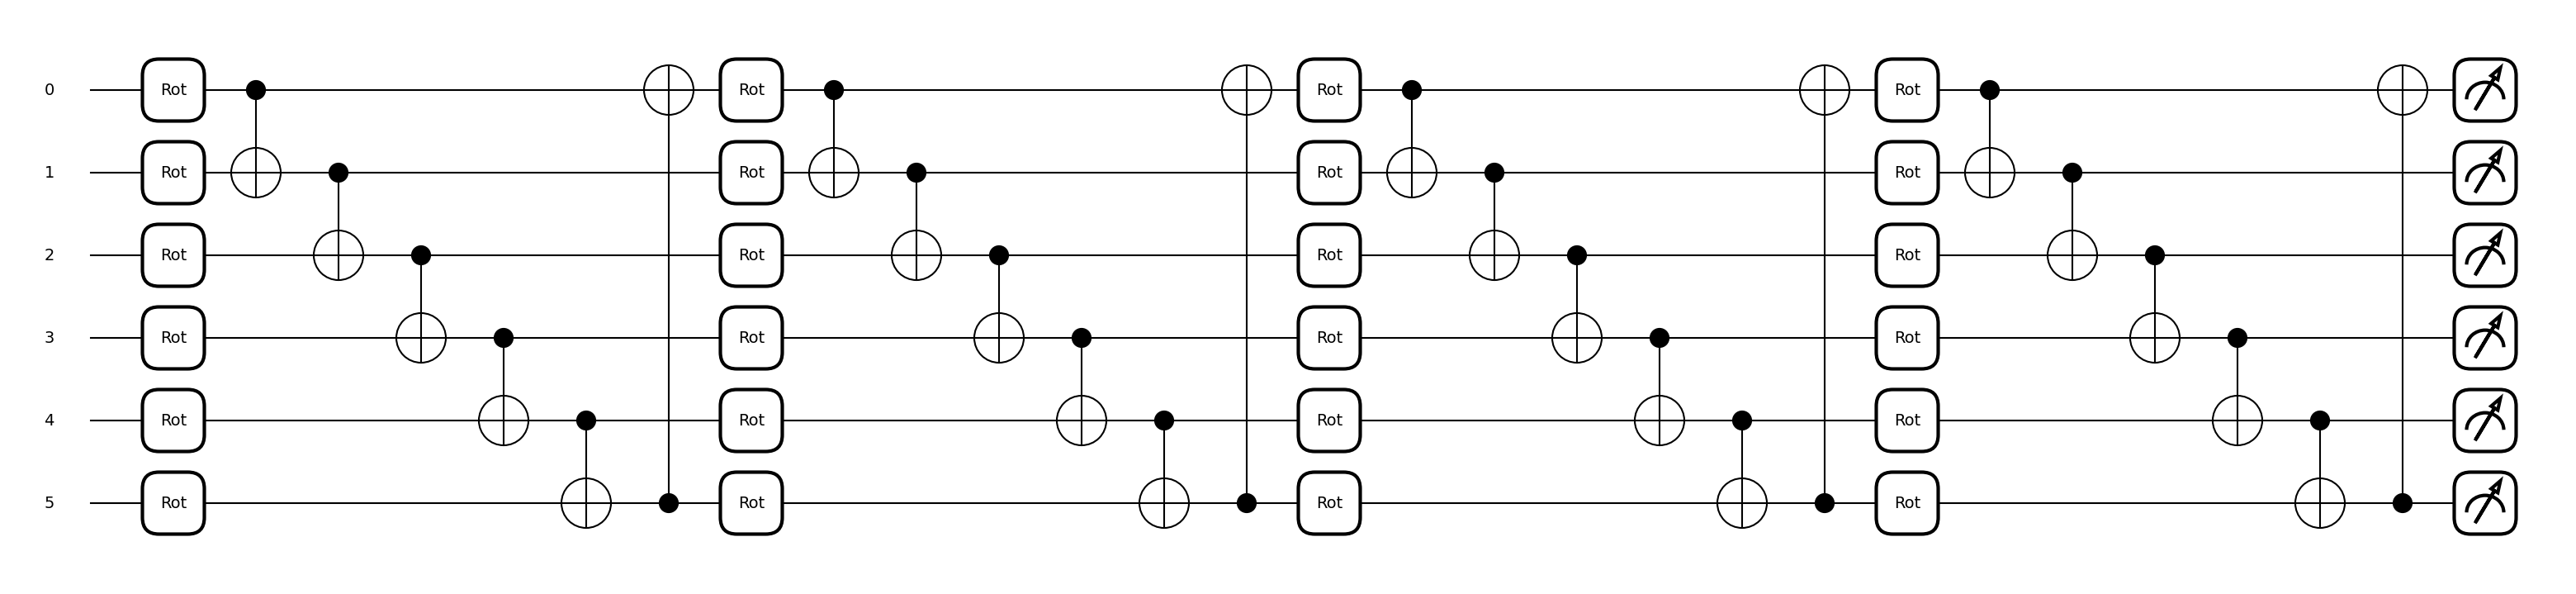

Step: 0 Loss: 0.0142 KL-div: 0.7283
Step: 1 Loss: 0.0058 KL-div: 0.4160
Step: 2 Loss: 0.0063 KL-div: 0.4939
Step: 3 Loss: 0.0070 KL-div: 0.5574
Step: 4 Loss: 0.0060 KL-div: 0.5334
Step: 5 Loss: 0.0049 KL-div: 0.4679
Step: 6 Loss: 0.0041 KL-div: 0.3955
Step: 7 Loss: 0.0034 KL-div: 0.3554
Step: 8 Loss: 0.0032 KL-div: 0.3641
Step: 9 Loss: 0.0031 KL-div: 0.2919
Step: 10 Loss: 0.0030 KL-div: 0.2824
Step: 11 Loss: 0.0028 KL-div: 0.2823
Step: 12 Loss: 0.0027 KL-div: 0.2879
Step: 13 Loss: 0.0025 KL-div: 0.2502
Step: 14 Loss: 0.0022 KL-div: 0.2029
Step: 15 Loss: 0.0021 KL-div: 0.1689
Step: 16 Loss: 0.0021 KL-div: 0.1490
Step: 17 Loss: 0.0020 KL-div: 0.1387
Step: 18 Loss: 0.0020 KL-div: 0.1323
Step: 19 Loss: 0.0018 KL-div: 0.1235
Step: 20 Loss: 0.0016 KL-div: 0.1118
Step: 21 Loss: 0.0014 KL-div: 0.1024
Step: 22 Loss: 0.0014 KL-div: 0.0984
Step: 23 Loss: 0.0013 KL-div: 0.0981
Step: 24 Loss: 0.0013 KL-div: 0.0996
Step: 25 Loss: 0.0012 KL-div: 0.1016
Step: 26 Loss: 0.0012 KL-div: 0.1031
Step: 27 Lo

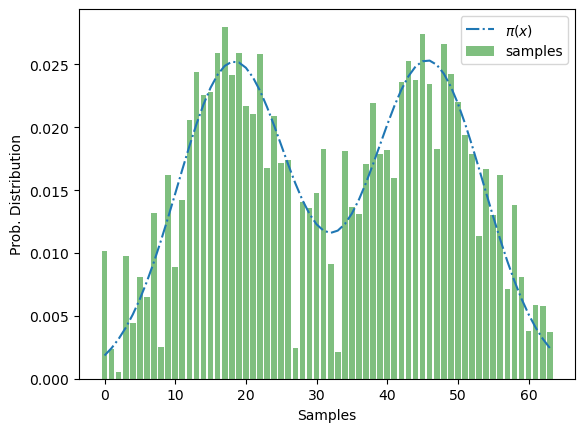

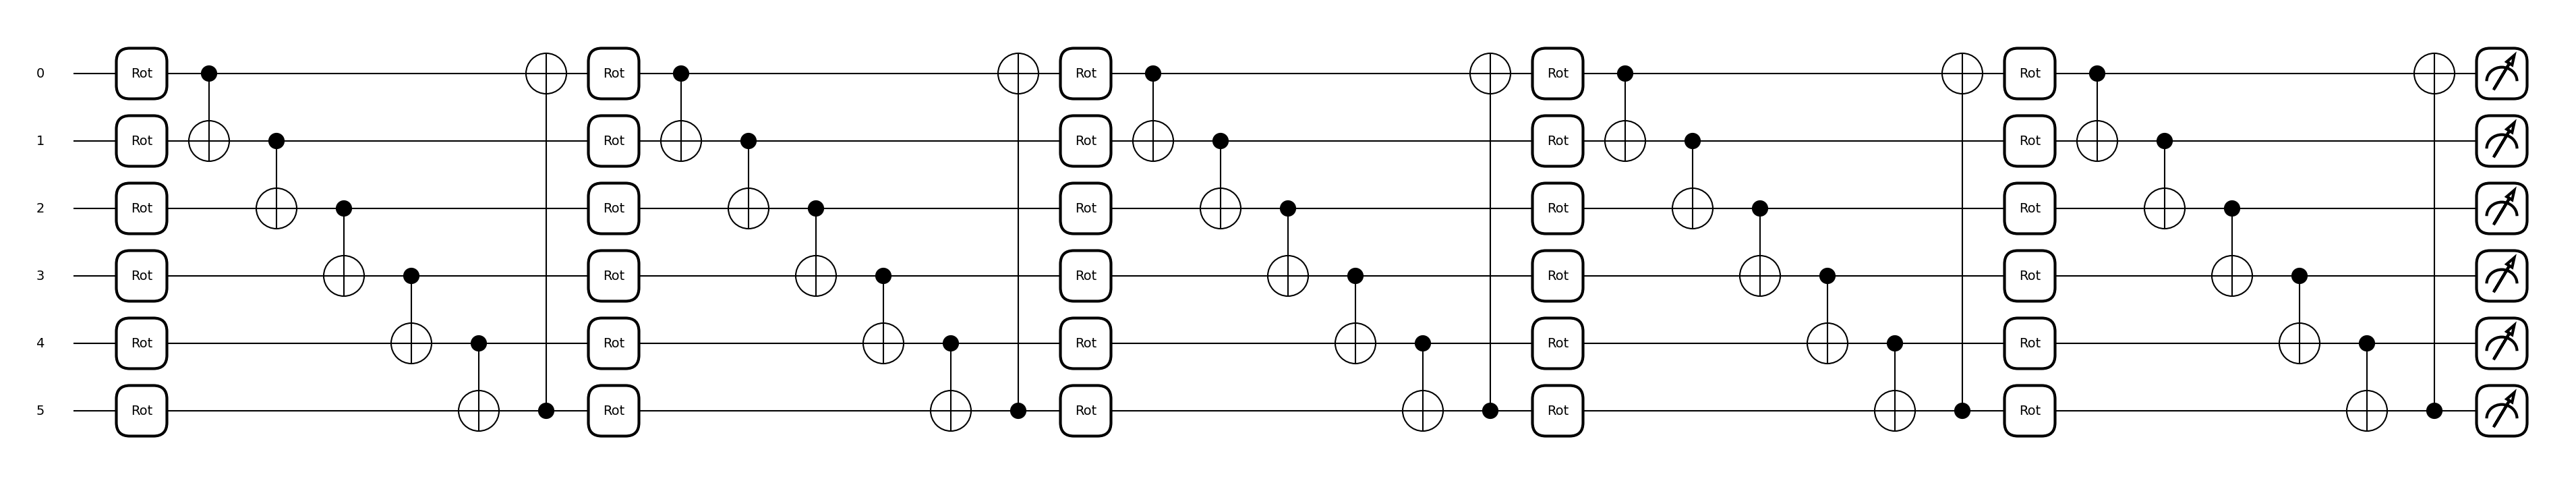

Step: 0 Loss: 0.0224 KL-div: 0.7190
Step: 1 Loss: 0.0145 KL-div: 0.8486
Step: 2 Loss: 0.0111 KL-div: 0.6860
Step: 3 Loss: 0.0081 KL-div: 0.5206
Step: 4 Loss: 0.0064 KL-div: 0.5382
Step: 5 Loss: 0.0065 KL-div: 0.6241
Step: 6 Loss: 0.0064 KL-div: 0.6217
Step: 7 Loss: 0.0052 KL-div: 0.5283
Step: 8 Loss: 0.0045 KL-div: 0.4445
Step: 9 Loss: 0.0044 KL-div: 0.4162
Step: 10 Loss: 0.0040 KL-div: 0.3988
Step: 11 Loss: 0.0033 KL-div: 0.3425
Step: 12 Loss: 0.0029 KL-div: 0.3138
Step: 13 Loss: 0.0030 KL-div: 0.2993
Step: 14 Loss: 0.0030 KL-div: 0.2821
Step: 15 Loss: 0.0027 KL-div: 0.2553
Step: 16 Loss: 0.0023 KL-div: 0.2259
Step: 17 Loss: 0.0021 KL-div: 0.2074
Step: 18 Loss: 0.0019 KL-div: 0.1747
Step: 19 Loss: 0.0018 KL-div: 0.1465
Step: 20 Loss: 0.0016 KL-div: 0.1364
Step: 21 Loss: 0.0014 KL-div: 0.1421
Step: 22 Loss: 0.0012 KL-div: 0.1592
Step: 23 Loss: 0.0011 KL-div: 0.1226
Step: 24 Loss: 0.0010 KL-div: 0.1061
Step: 25 Loss: 0.0010 KL-div: 0.0984
Step: 26 Loss: 0.0010 KL-div: 0.0968
Step: 27 Lo

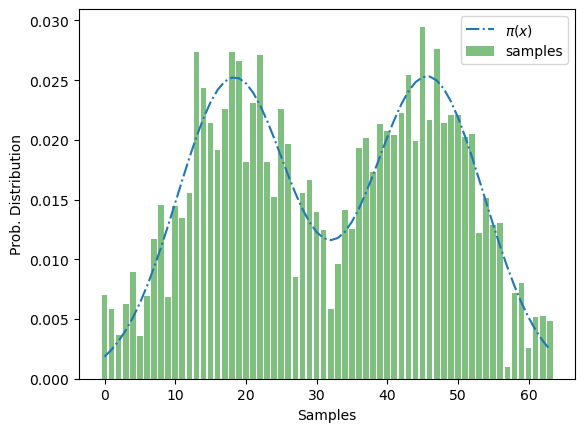

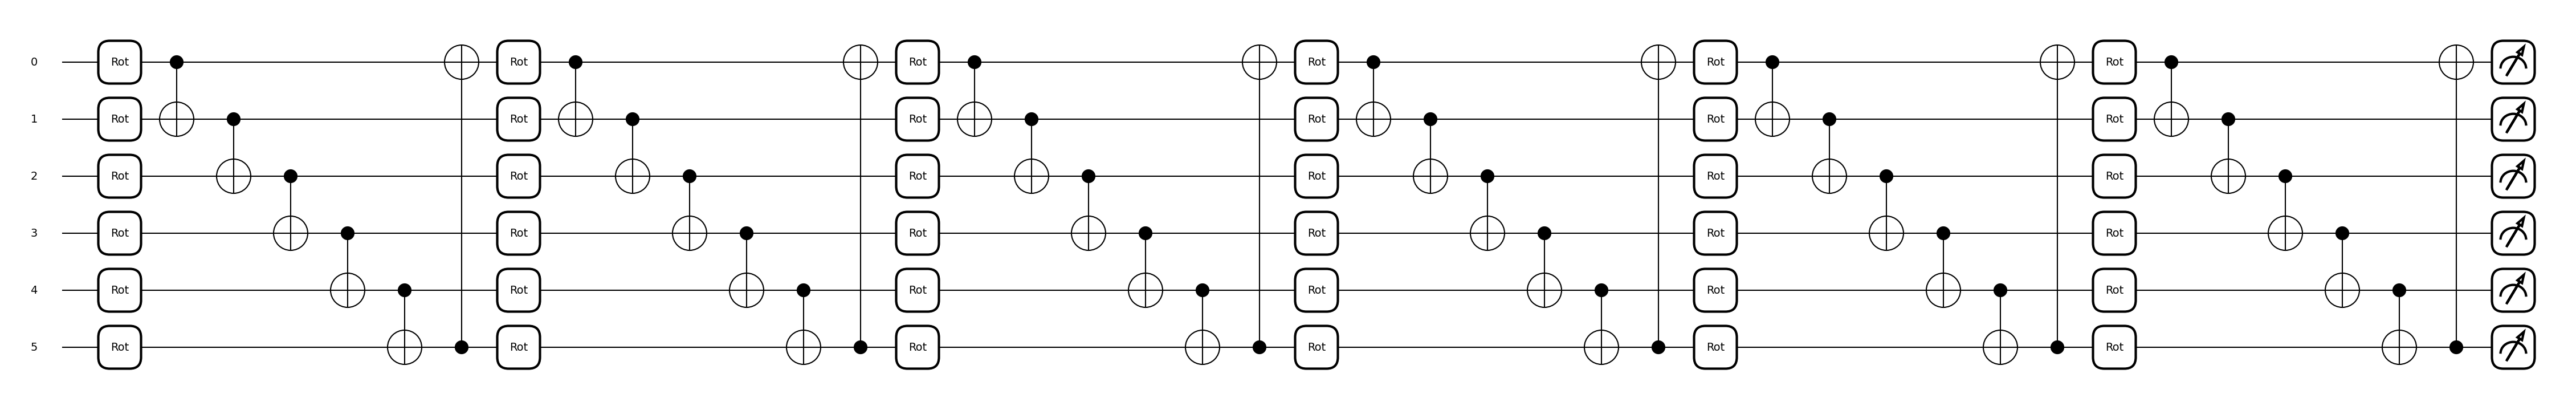

Step: 0 Loss: 0.0152 KL-div: 0.7248
Step: 1 Loss: 0.0065 KL-div: 0.5013
Step: 2 Loss: 0.0062 KL-div: 0.5048
Step: 3 Loss: 0.0053 KL-div: 0.4067
Step: 4 Loss: 0.0041 KL-div: 0.3104
Step: 5 Loss: 0.0029 KL-div: 0.2244
Step: 6 Loss: 0.0028 KL-div: 0.2041
Step: 7 Loss: 0.0027 KL-div: 0.2167
Step: 8 Loss: 0.0027 KL-div: 0.2223
Step: 9 Loss: 0.0024 KL-div: 0.1985
Step: 10 Loss: 0.0017 KL-div: 0.1480
Step: 11 Loss: 0.0012 KL-div: 0.1029
Step: 12 Loss: 0.0012 KL-div: 0.0951
Step: 13 Loss: 0.0014 KL-div: 0.1142
Step: 14 Loss: 0.0014 KL-div: 0.1304
Step: 15 Loss: 0.0013 KL-div: 0.1331
Step: 16 Loss: 0.0010 KL-div: 0.1212
Step: 17 Loss: 0.0009 KL-div: 0.1028
Step: 18 Loss: 0.0008 KL-div: 0.0909
Step: 19 Loss: 0.0008 KL-div: 0.0909
Step: 20 Loss: 0.0008 KL-div: 0.0971
Step: 21 Loss: 0.0007 KL-div: 0.0948
Step: 22 Loss: 0.0006 KL-div: 0.0852
Step: 23 Loss: 0.0005 KL-div: 0.0788
Step: 24 Loss: 0.0005 KL-div: 0.0743
Step: 25 Loss: 0.0004 KL-div: 0.0665
Step: 26 Loss: 0.0004 KL-div: 0.0572
Step: 27 Lo

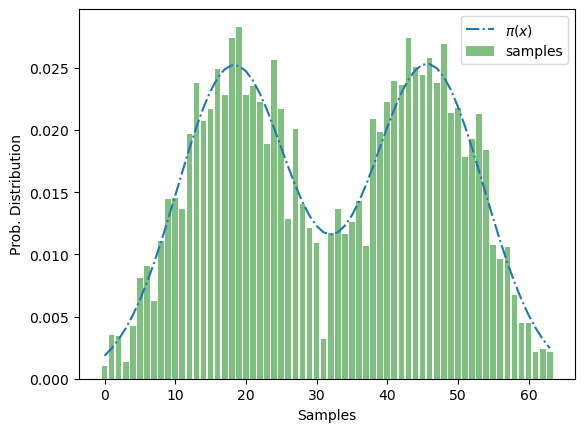

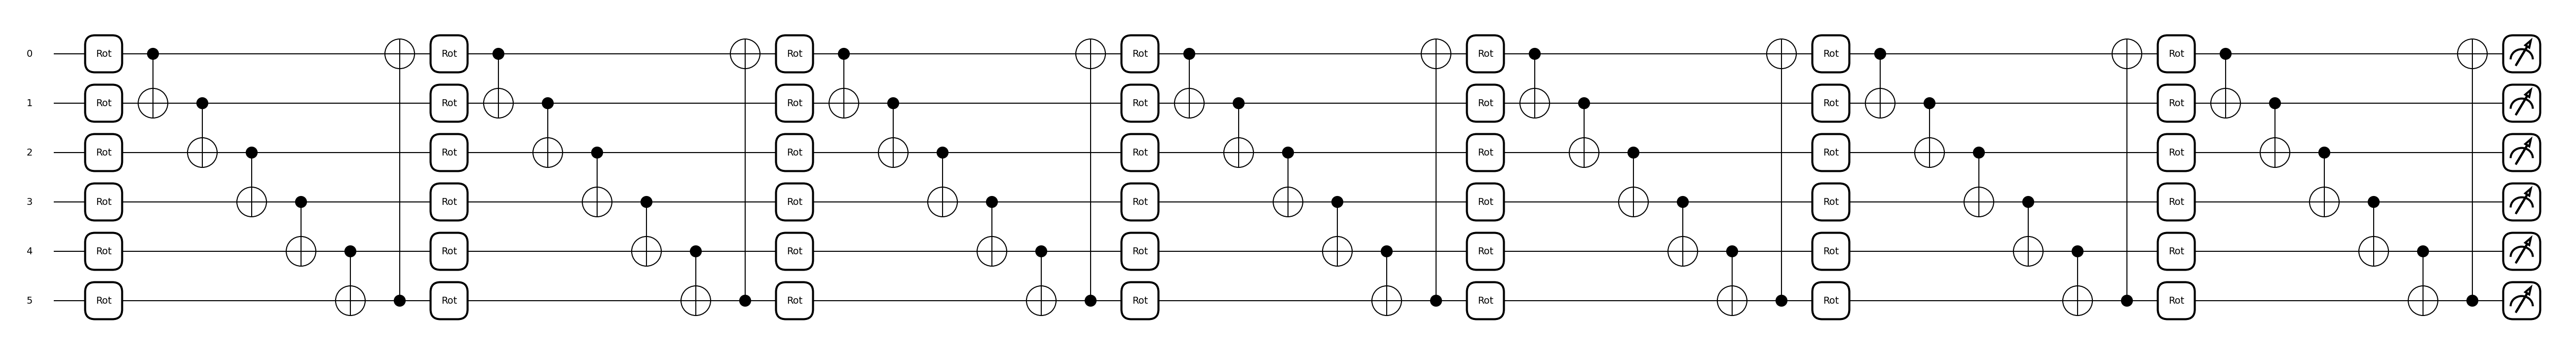

Step: 0 Loss: 0.0169 KL-div: 0.8334
Step: 1 Loss: 0.0121 KL-div: 0.7103
Step: 2 Loss: 0.0063 KL-div: 0.5462
Step: 3 Loss: 0.0056 KL-div: 0.3849
Step: 4 Loss: 0.0047 KL-div: 0.3114
Step: 5 Loss: 0.0037 KL-div: 0.3124
Step: 6 Loss: 0.0037 KL-div: 0.2465
Step: 7 Loss: 0.0033 KL-div: 0.2044
Step: 8 Loss: 0.0024 KL-div: 0.1886
Step: 9 Loss: 0.0020 KL-div: 0.1829
Step: 10 Loss: 0.0019 KL-div: 0.1684
Step: 11 Loss: 0.0018 KL-div: 0.1529
Step: 12 Loss: 0.0017 KL-div: 0.1612
Step: 13 Loss: 0.0015 KL-div: 0.1949
Step: 14 Loss: 0.0012 KL-div: 0.1397
Step: 15 Loss: 0.0010 KL-div: 0.1174
Step: 16 Loss: 0.0010 KL-div: 0.1066
Step: 17 Loss: 0.0010 KL-div: 0.1045
Step: 18 Loss: 0.0009 KL-div: 0.1038
Step: 19 Loss: 0.0008 KL-div: 0.0999
Step: 20 Loss: 0.0007 KL-div: 0.0918
Step: 21 Loss: 0.0005 KL-div: 0.0762
Step: 22 Loss: 0.0005 KL-div: 0.0579
Step: 23 Loss: 0.0004 KL-div: 0.0446
Step: 24 Loss: 0.0004 KL-div: 0.0391
Step: 25 Loss: 0.0004 KL-div: 0.0381
Step: 26 Loss: 0.0004 KL-div: 0.0374
Step: 27 Lo

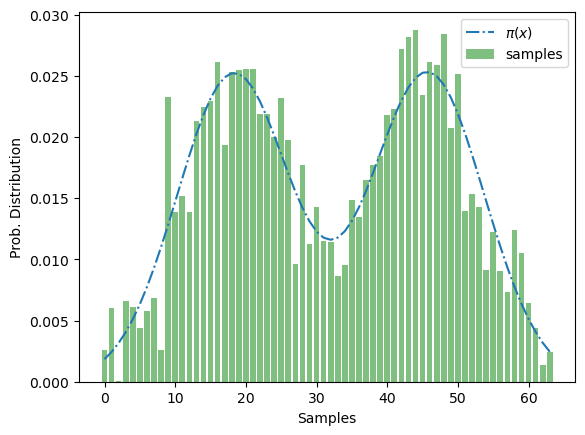

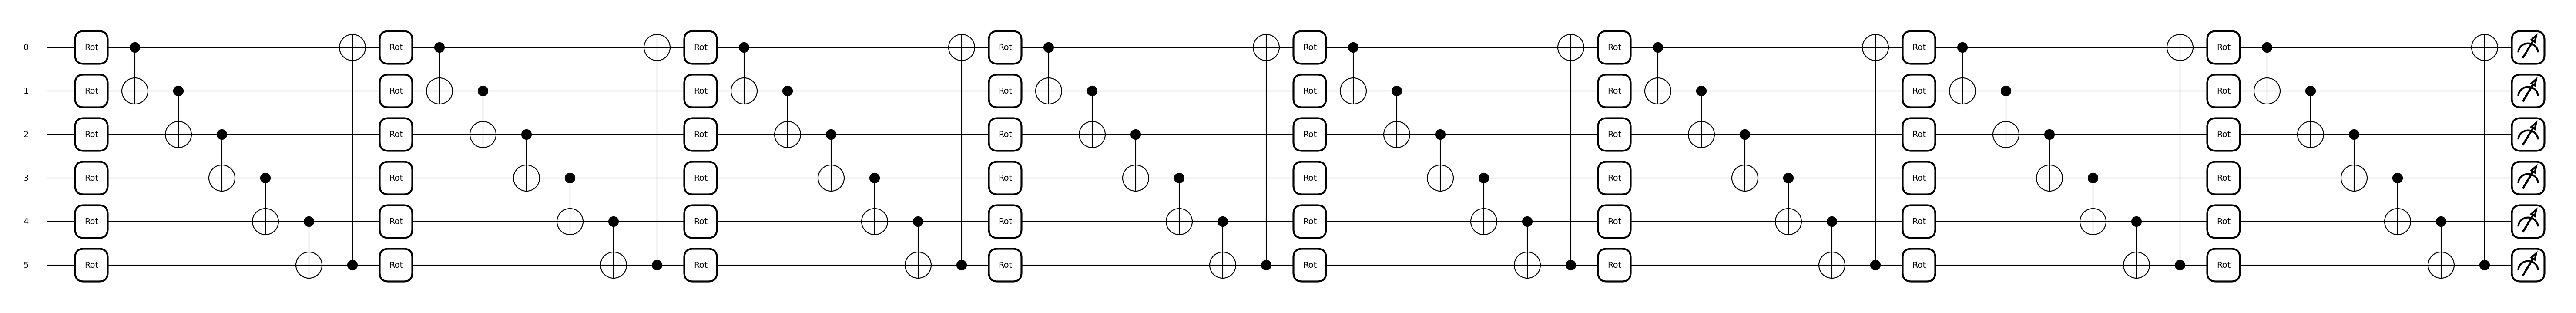

Step: 0 Loss: 0.0134 KL-div: 0.6774
Step: 1 Loss: 0.0070 KL-div: 0.4916
Step: 2 Loss: 0.0047 KL-div: 0.3219
Step: 3 Loss: 0.0051 KL-div: 0.3602
Step: 4 Loss: 0.0039 KL-div: 0.3009
Step: 5 Loss: 0.0030 KL-div: 0.2229
Step: 6 Loss: 0.0022 KL-div: 0.1901
Step: 7 Loss: 0.0021 KL-div: 0.1681
Step: 8 Loss: 0.0016 KL-div: 0.1290
Step: 9 Loss: 0.0015 KL-div: 0.1080
Step: 10 Loss: 0.0015 KL-div: 0.1047
Step: 11 Loss: 0.0013 KL-div: 0.1025
Step: 12 Loss: 0.0012 KL-div: 0.0949
Step: 13 Loss: 0.0010 KL-div: 0.0821
Step: 14 Loss: 0.0009 KL-div: 0.0726
Step: 15 Loss: 0.0008 KL-div: 0.0625
Step: 16 Loss: 0.0006 KL-div: 0.0558
Step: 17 Loss: 0.0005 KL-div: 0.0571
Step: 18 Loss: 0.0005 KL-div: 0.0608
Step: 19 Loss: 0.0005 KL-div: 0.0612
Step: 20 Loss: 0.0005 KL-div: 0.0596
Step: 21 Loss: 0.0004 KL-div: 0.0558
Step: 22 Loss: 0.0003 KL-div: 0.0507
Step: 23 Loss: 0.0003 KL-div: 0.0458
Step: 24 Loss: 0.0003 KL-div: 0.0405


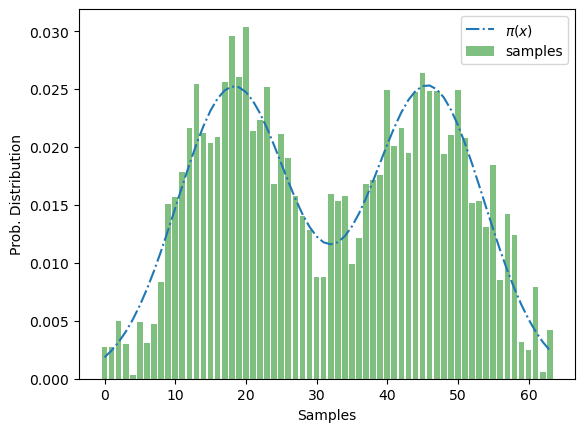

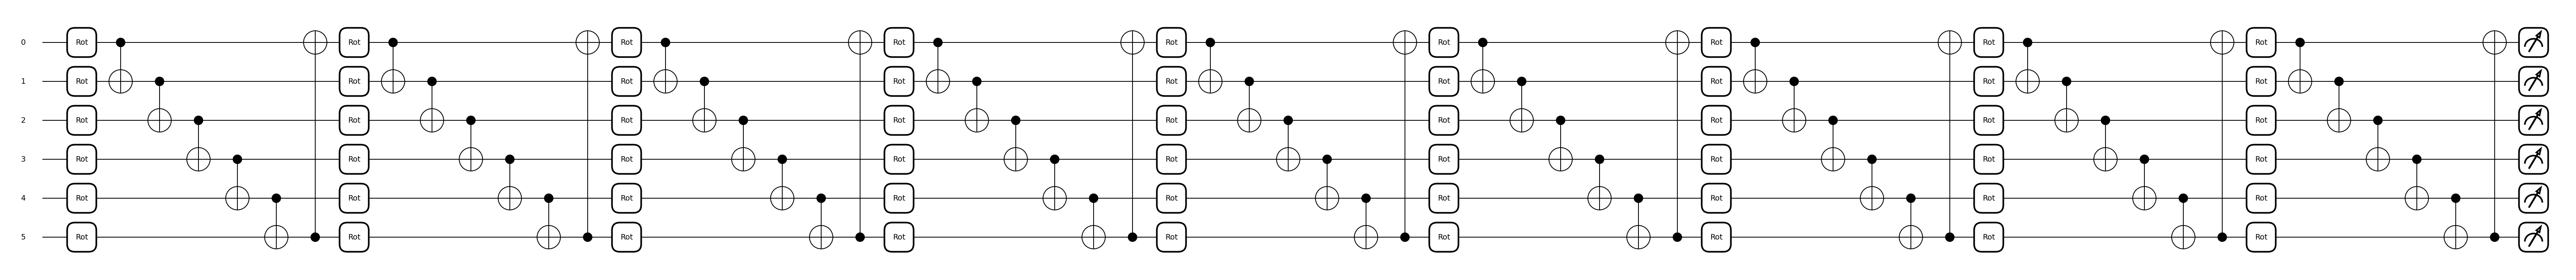

Step: 0 Loss: 0.0167 KL-div: 0.6607
Step: 1 Loss: 0.0109 KL-div: 0.6119
Step: 2 Loss: 0.0072 KL-div: 0.5585
Step: 3 Loss: 0.0066 KL-div: 0.6372
Step: 4 Loss: 0.0053 KL-div: 0.6834
Step: 5 Loss: 0.0060 KL-div: 0.5093
Step: 6 Loss: 0.0045 KL-div: 0.4061
Step: 7 Loss: 0.0032 KL-div: 0.2779
Step: 8 Loss: 0.0019 KL-div: 0.1853
Step: 9 Loss: 0.0018 KL-div: 0.1655
Step: 10 Loss: 0.0017 KL-div: 0.1789
Step: 11 Loss: 0.0020 KL-div: 0.2002
Step: 12 Loss: 0.0019 KL-div: 0.1938
Step: 13 Loss: 0.0016 KL-div: 0.1710
Step: 14 Loss: 0.0014 KL-div: 0.1508
Step: 15 Loss: 0.0012 KL-div: 0.1367
Step: 16 Loss: 0.0011 KL-div: 0.1326
Step: 17 Loss: 0.0011 KL-div: 0.1290
Step: 18 Loss: 0.0010 KL-div: 0.1167
Step: 19 Loss: 0.0009 KL-div: 0.1053
Step: 20 Loss: 0.0009 KL-div: 0.0920
Step: 21 Loss: 0.0007 KL-div: 0.0713


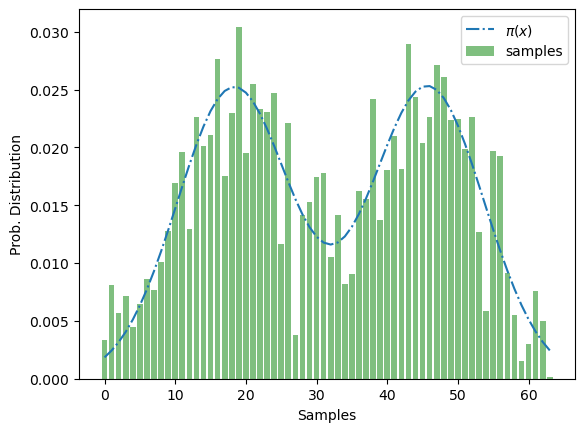

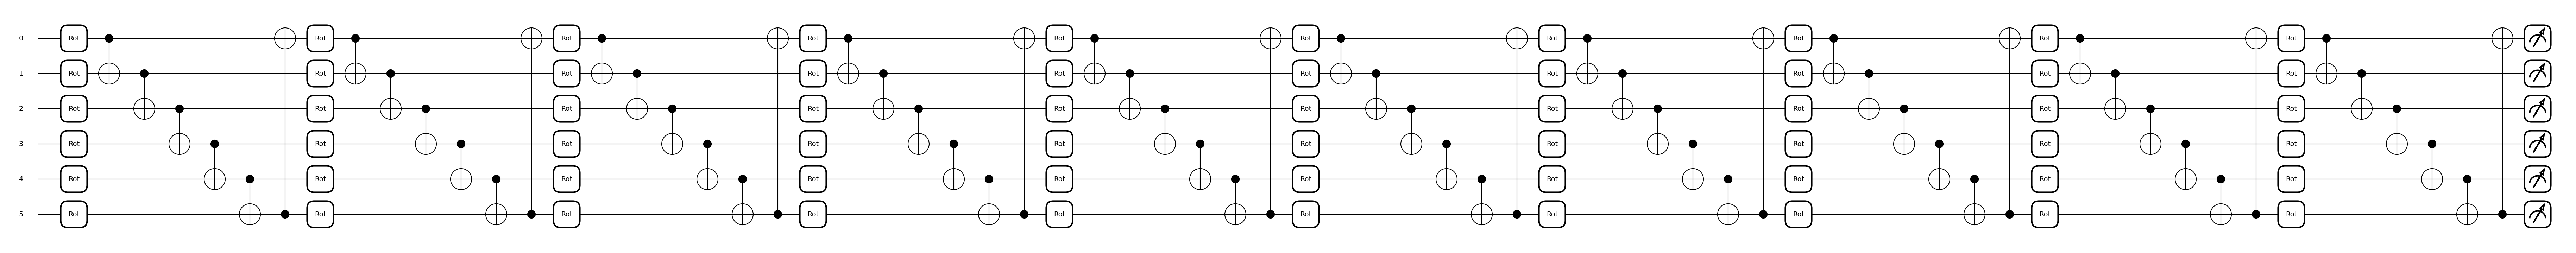

Step: 0 Loss: 0.0079 KL-div: 0.6894
Step: 1 Loss: 0.0106 KL-div: 0.6604
Step: 2 Loss: 0.0081 KL-div: 0.6222
Step: 3 Loss: 0.0057 KL-div: 0.4660
Step: 4 Loss: 0.0043 KL-div: 0.3665
Step: 5 Loss: 0.0035 KL-div: 0.3444
Step: 6 Loss: 0.0031 KL-div: 0.3480
Step: 7 Loss: 0.0024 KL-div: 0.3185
Step: 8 Loss: 0.0024 KL-div: 0.2541
Step: 9 Loss: 0.0021 KL-div: 0.2115
Step: 10 Loss: 0.0017 KL-div: 0.1570
Step: 11 Loss: 0.0014 KL-div: 0.1130
Step: 12 Loss: 0.0012 KL-div: 0.0860
Step: 13 Loss: 0.0010 KL-div: 0.0736
Step: 14 Loss: 0.0009 KL-div: 0.0659
Step: 15 Loss: 0.0008 KL-div: 0.0594
Step: 16 Loss: 0.0007 KL-div: 0.0502
Step: 17 Loss: 0.0005 KL-div: 0.0426
Step: 18 Loss: 0.0005 KL-div: 0.0378
Step: 19 Loss: 0.0005 KL-div: 0.0343


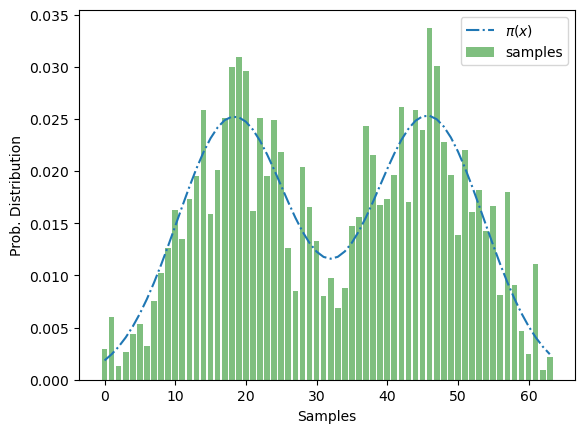

In [87]:
nLayers_test = [1,2,3,4,5,6,7,8,9,10]
for test in nLayers_test:
    QCBM_N_layers_run(n_layers = test)

# Testing different Ansatz

### Mathematical Respresentation of Ansatz

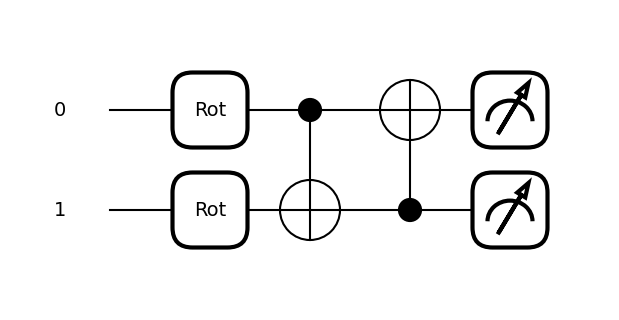

In [90]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 1
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)

@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [212]:
from sympy import Matrix, symbols, cos, sin, exp, I

# Define the angle theta as a symbol
theta = symbols('theta')

# CNOT gate matrix (control qubit on the first, target qubit on the second)
CNOT = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

def I():
    return Matrix([
        [1,0],
        [0,1]
    ])

# Function to create RZ gate with a given angle name
def RZ(angle_name="theta"):
    angle = symbols(angle_name)  # Create a symbolic variable for the angle
    return Matrix([
        [exp(-I * angle / 2), 0],
        [0, exp(I * angle / 2)]
    ])

def RY(angle_name = "theta"):
    angle = symbols(angle_name)  # Create a symbolic variable for the angle
    return Matrix([
        [cos(angle / 2), - sin(angle / 2)],
        [sin(angle/ 2), cos(angle / 2)]
    ])

def RX(angle_name = "theta"):
    angle = symbols(angle_name)  # Create a symbolic variable for the angle
    return Matrix([
        [cos(angle / 2), sin(angle / 2)],
        [sin(angle/ 2), cos(angle / 2)]
    ])

In [194]:
from sympy import tensorproduct

def CNOT_gate(Control_U, Target_U):
    # CNOT gate matrix (control qubit on the first, target qubit on the second)
    CNOT = Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ])

    TargetControl_tensor = tensorproduct(Control_U, Target_U).as_mutable()
    TargetControl_Matrix = Matrix(4, 4, lambda i, j: TargetControl_tensor[i // 2][j // 2][i % 2][j % 2])
    return TargetControl_Matrix @ CNOT

In [195]:
CNOT_gate(RX(), RY())

Matrix([
[          cos(theta/2)**2, -sin(theta/2)*cos(theta/2),           -sin(theta/2)**2, sin(theta/2)*cos(theta/2)],
[sin(theta/2)*cos(theta/2),            cos(theta/2)**2,  sin(theta/2)*cos(theta/2),           sin(theta/2)**2],
[sin(theta/2)*cos(theta/2),           -sin(theta/2)**2, -sin(theta/2)*cos(theta/2),           cos(theta/2)**2],
[          sin(theta/2)**2,  sin(theta/2)*cos(theta/2),            cos(theta/2)**2, sin(theta/2)*cos(theta/2)]])

In [196]:
def Arbritray_Unitary(theta1 = "alpha", theta2 = "beta", theta3= "gamma"):
    return RZ(theta1) @ RY(theta2) @ RZ(theta3)

In [216]:
Arbritray_Unitary(theta1 = "alpha_0", theta2 = "beta_0", theta3= "gamma_0")

Matrix([
[exp(-I*alpha_0/2)*exp(-I*gamma_0/2)*cos(beta_0/2), -exp(-I*alpha_0/2)*exp(I*gamma_0/2)*sin(beta_0/2)],
[ exp(I*alpha_0/2)*exp(-I*gamma_0/2)*sin(beta_0/2),   exp(I*alpha_0/2)*exp(I*gamma_0/2)*cos(beta_0/2)]])

In [226]:
from sympy import tensorproduct

AU0 = Arbritray_Unitary(theta1 = "alpha_0", theta2 = "beta_0", theta3= "gamma_0")
AU1 = Arbritray_Unitary(theta1 = "alpha_1", theta2 = "beta_1", theta3= "gamma_1")

AU0_AU1_tensor = tensorproduct(AU0, AU1)
AU0_AU1 = Matrix(4, 4, lambda i, j: AU0_AU1_tensor[i // 2][j // 2][i % 2][j % 2])

AU1_AU0_tensor = tensorproduct(AU1, AU0)
AU1_AU0 = Matrix(4, 4, lambda i, j: AU1_AU0_tensor[i // 2][j // 2][i % 2][j % 2])

In [224]:
AU0_AU1 @ CNOT_gate(AU0,AU1) @ CNOT_gate(AU1, AU0)

Matrix([
[(sin(beta_0/2)**2*sin(beta_1/2)**2 - exp(-I*alpha_1)*exp(-I*gamma_1)*sin(beta_0/2)**2*cos(beta_1/2)**2 - exp(-I*alpha_0)*exp(-I*gamma_0)*sin(beta_1/2)**2*cos(beta_0/2)**2 + exp(-I*alpha_0)*exp(-I*alpha_1)*exp(-I*gamma_0)*exp(-I*gamma_1)*cos(beta_0/2)**2*cos(beta_1/2)**2)*exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2) + (exp(I*gamma_0)*sin(beta_0/2)*sin(beta_1/2)**2*cos(beta_0/2) - exp(-I*alpha_1)*exp(I*gamma_0)*exp(-I*gamma_1)*sin(beta_0/2)*cos(beta_0/2)*cos(beta_1/2)**2 + exp(-I*alpha_0)*sin(beta_0/2)*sin(beta_1/2)**2*cos(beta_0/2) - exp(-I*alpha_0)*exp(-I*alpha_1)*exp(-I*gamma_1)*sin(beta_0/2)*cos(beta_0/2)*cos(beta_1/2)**2)*exp(I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2) + (exp(I*gamma_1)*sin(beta_0/2)**2*sin(beta_1/2)*cos(beta_1/2) + exp(-I*alpha_1)*sin(beta_0/2)**2*sin(beta_1/2)*cos(beta_1/2) - exp(-I*alpha_0)*exp(-I*gamma_0)*exp(I*gamma_1)*sin(beta_1/2)*cos(beta_0/2)**

In [225]:
AU0_AU1

Matrix([
[exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2), exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2)],
[ exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2),   exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2),  -exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2), -exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2)],
[ exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2),  -exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_

In [227]:
AU1_AU0

Matrix([
[exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2), exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2)],
[ exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2),   exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2),  -exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2), -exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2)],
[ exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2),  -exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_

## Add Hadamards to intial state in ansatz 
#### |+> intial state versus |0> state

## Vary Initial Conditions